In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

MODEL = "gpt-4o-mini"
openai = OpenAI()

system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [2]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

c:\Users\veace\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:279: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [6]:
ticket_prices = {"london": "$799",
                 "paris": "$899",
                 "tokyo": "$1400",
                 "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [7]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city" : {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]

In [8]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content


def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get("destination_city")
    price=get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": message.tool_calls[0].id
    }

    return response, city


gr.ChatInterface(fn=chat).launch()

c:\Users\veace\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:279: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Tool get_ticket_price called for Paris
Tool get_ticket_price called for Tokyo
Tool get_ticket_price called for Madrid


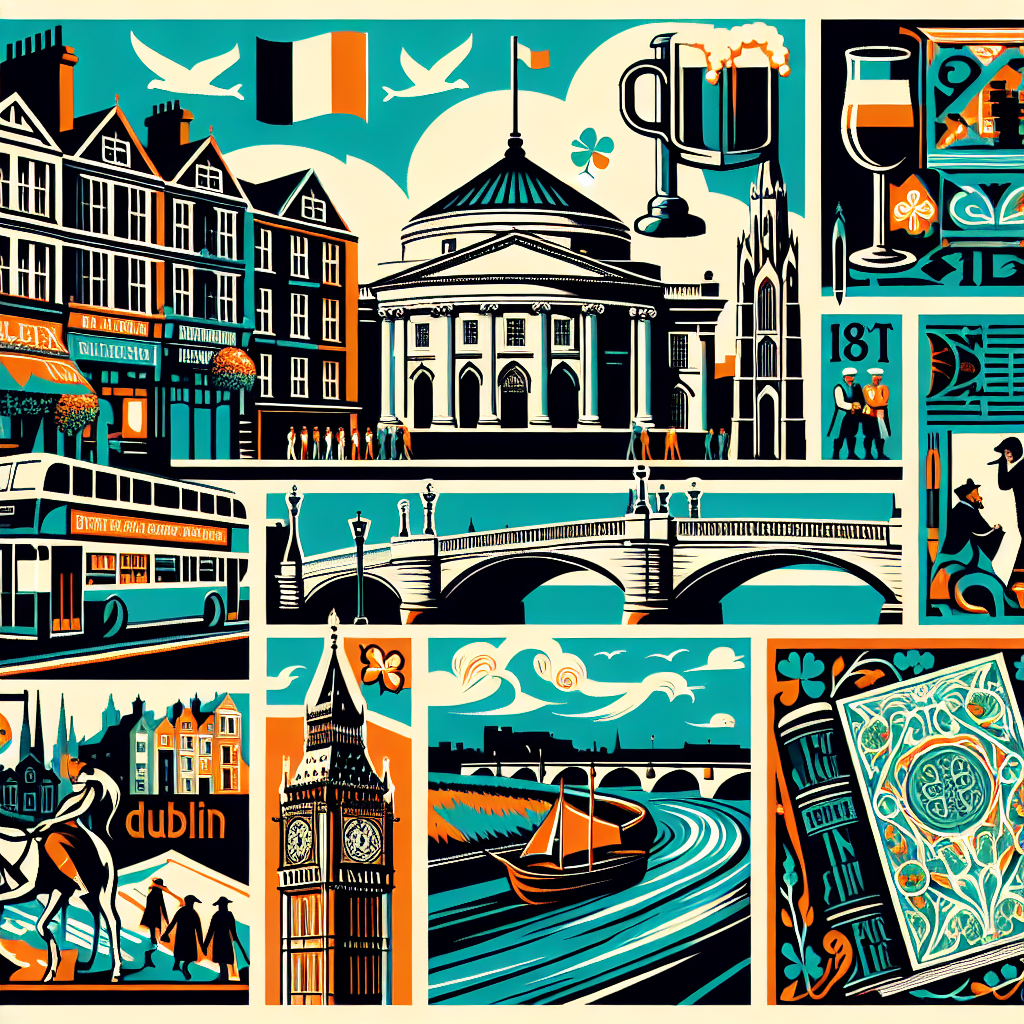

In [13]:
import base64
from io import BytesIO
from PIL import Image

def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size = "1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))


image = artist("Dublin")

display(image)